**BASIC CIFAS EXAMPLE WITH CONV**

Imports...

In [1]:
from numpy.random import seed
seed(86148)

from __future__ import print_function

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization as BN
from tensorflow.keras.layers import GaussianNoise as GN
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler as LRS
from tensorflow.keras import regularizers 

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
batch_size = 128
epochs = 250
num_classes = 10


In [3]:
#### LOAD AND TRANSFORM
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

print(x_train.shape)
print(x_test.shape)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [4]:
def scheduler(epoch):
    return 0.1 * (0.5 ** (epoch // 20))

In [5]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    rotation_range = 15,
)

datagen.fit(x_train)

'\ngenerator = MixupGenerator(x_train, y_train, alpha=0.2, datagen=datagen)()\n'

In [6]:
## DEF NN TOPOLOGY  

model = Sequential()

weight_decay = 0.0005

model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=x_train.shape[1:],kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BN())
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BN())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BN())
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BN())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BN())
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BN())
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BN())

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BN())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BN())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BN())

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BN())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BN())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BN())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BN())

model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))





Metal device set to: Apple M1


2022-01-02 13:45:59.651514: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-02 13:45:59.651613: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
## OPTIM AND COMPILE
opt = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        2

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [8]:
filepath_val_acc="./backup/model.best.hdf5"
checkpoint_val_acc = ModelCheckpoint(filepath_val_acc, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint_val_acc]    
    
## TRAINING
history = model.fit(
    datagen.flow(x_train,y_train,batch_size=batch_size),  
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test),
    shuffle=True,
    callbacks=[LRS(scheduler), checkpoint_val_acc]
)



2022-01-02 13:46:00.051206: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-02 13:46:00.051321: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/250


2022-01-02 13:46:00.470545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


390/390 [==============================] - ETA: 0s - loss: 22.0426 - accuracy: 0.1779

2022-01-02 13:47:33.529177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


390/390 [==============================] - 100s 254ms/step - loss: 22.0426 - accuracy: 0.1779 - val_loss: 16.0137 - val_accuracy: 0.0971

Epoch 00001: val_accuracy improved from -inf to 0.09710, saving model to ./backup/model.best.hdf5
Epoch 2/250
390/390 [==============================] - 98s 251ms/step - loss: 11.2561 - accuracy: 0.2689 - val_loss: 9.2212 - val_accuracy: 0.0919

Epoch 00002: val_accuracy did not improve from 0.09710
Epoch 3/250
390/390 [==============================] - 99s 253ms/step - loss: 6.0922 - accuracy: 0.3323 - val_loss: 5.6555 - val_accuracy: 0.1451

Epoch 00003: val_accuracy improved from 0.09710 to 0.14510, saving model to ./backup/model.best.hdf5
Epoch 4/250
390/390 [==============================] - 102s 262ms/step - loss: 3.6712 - accuracy: 0.4270 - val_loss: 3.8153 - val_accuracy: 0.2653

Epoch 00004: val_accuracy improved from 0.14510 to 0.26530, saving model to ./backup/model.best.hdf5
Epoch 5/250
390/390 [==============================] - 102s 262m

390/390 [==============================] - 98s 250ms/step - loss: 0.7237 - accuracy: 0.8872 - val_loss: 0.7373 - val_accuracy: 0.8825

Epoch 00075: val_accuracy did not improve from 0.89670
Epoch 76/250
390/390 [==============================] - 98s 250ms/step - loss: 0.7290 - accuracy: 0.8870 - val_loss: 0.7391 - val_accuracy: 0.8836

Epoch 00076: val_accuracy did not improve from 0.89670
Epoch 77/250
390/390 [==============================] - 98s 251ms/step - loss: 0.7292 - accuracy: 0.8855 - val_loss: 0.7493 - val_accuracy: 0.8815

Epoch 00077: val_accuracy did not improve from 0.89670
Epoch 78/250
390/390 [==============================] - 98s 251ms/step - loss: 0.7248 - accuracy: 0.8887 - val_loss: 0.7289 - val_accuracy: 0.8896

Epoch 00078: val_accuracy did not improve from 0.89670
Epoch 79/250
390/390 [==============================] - 98s 251ms/step - loss: 0.7280 - accuracy: 0.8871 - val_loss: 0.7769 - val_accuracy: 0.8752

Epoch 00079: val_accuracy did not improve from 0.8967

390/390 [==============================] - 98s 250ms/step - loss: 0.4246 - accuracy: 0.9473 - val_loss: 0.5492 - val_accuracy: 0.9141

Epoch 00114: val_accuracy did not improve from 0.92600
Epoch 115/250
390/390 [==============================] - 98s 251ms/step - loss: 0.4218 - accuracy: 0.9469 - val_loss: 0.5367 - val_accuracy: 0.9144

Epoch 00115: val_accuracy did not improve from 0.92600
Epoch 116/250
390/390 [==============================] - 98s 251ms/step - loss: 0.4174 - accuracy: 0.9484 - val_loss: 0.5181 - val_accuracy: 0.9214

Epoch 00116: val_accuracy did not improve from 0.92600
Epoch 117/250
390/390 [==============================] - 100s 256ms/step - loss: 0.4207 - accuracy: 0.9458 - val_loss: 0.5134 - val_accuracy: 0.9221

Epoch 00117: val_accuracy did not improve from 0.92600
Epoch 118/250
390/390 [==============================] - 98s 251ms/step - loss: 0.4191 - accuracy: 0.9471 - val_loss: 0.5266 - val_accuracy: 0.9173

Epoch 00118: val_accuracy did not improve from 0

390/390 [==============================] - 98s 252ms/step - loss: 0.2427 - accuracy: 0.9827 - val_loss: 0.4476 - val_accuracy: 0.9318

Epoch 00192: val_accuracy did not improve from 0.93270
Epoch 193/250
390/390 [==============================] - 98s 251ms/step - loss: 0.2437 - accuracy: 0.9833 - val_loss: 0.4485 - val_accuracy: 0.9308

Epoch 00193: val_accuracy did not improve from 0.93270
Epoch 194/250
390/390 [==============================] - 98s 252ms/step - loss: 0.2411 - accuracy: 0.9835 - val_loss: 0.4543 - val_accuracy: 0.9306

Epoch 00194: val_accuracy did not improve from 0.93270
Epoch 195/250
390/390 [==============================] - 98s 250ms/step - loss: 0.2427 - accuracy: 0.9829 - val_loss: 0.4506 - val_accuracy: 0.9323

Epoch 00195: val_accuracy did not improve from 0.93270
Epoch 196/250
390/390 [==============================] - 98s 252ms/step - loss: 0.2389 - accuracy: 0.9847 - val_loss: 0.4497 - val_accuracy: 0.9328

Epoch 00196: val_accuracy improved from 0.93270 t

390/390 [==============================] - 98s 251ms/step - loss: 0.2331 - accuracy: 0.9851 - val_loss: 0.4487 - val_accuracy: 0.9337

Epoch 00231: val_accuracy did not improve from 0.93410
Epoch 232/250
390/390 [==============================] - 98s 251ms/step - loss: 0.2307 - accuracy: 0.9857 - val_loss: 0.4483 - val_accuracy: 0.9340

Epoch 00232: val_accuracy did not improve from 0.93410
Epoch 233/250
390/390 [==============================] - 98s 251ms/step - loss: 0.2314 - accuracy: 0.9855 - val_loss: 0.4487 - val_accuracy: 0.9330

Epoch 00233: val_accuracy did not improve from 0.93410
Epoch 234/250
390/390 [==============================] - 98s 252ms/step - loss: 0.2309 - accuracy: 0.9855 - val_loss: 0.4476 - val_accuracy: 0.9337

Epoch 00234: val_accuracy did not improve from 0.93410
Epoch 235/250
390/390 [==============================] - 98s 252ms/step - loss: 0.2304 - accuracy: 0.9854 - val_loss: 0.4485 - val_accuracy: 0.9328

Epoch 00235: val_accuracy did not improve from 0.

In [9]:
## TEST
score = model.evaluate(x_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(f"Test error: {((1-score[1]) * 100):.3f}%")

313/313 [==============================] - 6s 20ms/step - loss: 0.4475 - accuracy: 0.9336
Test loss: 0.44751617312431335
Test accuracy: 0.9336000680923462
Test error: 6.640%


In [10]:
import matplotlib.pyplot as plt

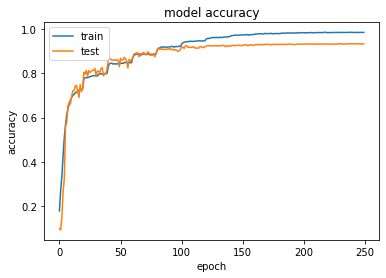

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()